In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
import datasets
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [4]:
from pathlib import Path
from glob import glob

In [5]:
base_path = './data/ecg_features_60s_clean_twa_rqa_60s'

In [6]:
participants = [Path(path).stem for path in glob(f'{base_path}/*.csv')]
train_participants, test_participants = train_test_split(participants, test_size=0.2, random_state=42)

In [7]:
def encode(baseline = 0, mental_stress = -1, high_physical_activity = -1, moderate_physical_activity = -1, low_physical_activity = -1):
    def inner(labels):
        baseline_list = ['Sitting', 'Recov1', 'Recov2', 'Recov3', 'Recov4', 'Recov5', 'Recov6']
        mental_stress_list = ['TA', 'SSST_Sing_countdown', 'Pasat', 'Raven', 'TA_repeat', 'Pasat_repeat']
        high_physical_stress_list = ['Treadmill1', 'Treadmill2', 'Treadmill3', 'Treadmill4', 'Walking_fast_pace', 'Cycling', 'stairs_up_and_down']
        moderate_physical_stress_list = ['Walking_own_pace', 'Dishes', 'Vacuum']
        low_physical_stress_list = ['Standing', 'Lying_supine', 'Recov_standing']
        
        def encode_multiclass(label):
            if label in baseline_list:
                return baseline
            elif label in mental_stress_list:
                return mental_stress
            elif label in high_physical_stress_list:
                return high_physical_activity
            elif label in moderate_physical_stress_list:
                return moderate_physical_activity
            elif label in low_physical_stress_list:
                return low_physical_activity
            else:
                return -1
            
        return {
            'label': [encode_multiclass(label) for label in labels],
        }
    return inner

def clean(dataset, mapping={}):
    dataset = dataset.map(
        encode(**mapping), 
        batched=True, 
        batch_size=2048, 
        input_columns=['label'],
        num_proc=4
    )
    return dataset.filter(
        lambda label: label != -1,
        input_columns=['label'],
    )


In [8]:
X_labels =  [
    "hrv_mean",
    "hrv_min",
    "hrv_max",
    "hrv_std",
    "hrv_rms",
    "hr_max",
    "rr_mean",
    "rr_min",
    "rr_max",
    "rr_std",
    "nn50",
    "pnn50",
    "rmssd",
    "MeanNN",
    "SDNN",
    "SDANN1",
    "SDNNI1",
    "SDANN2",
    "SDNNI2",
    "SDANN5",
    "SDNNI5",
    "RMSSD",
    "SDSD",
    "CVNN",
    "CVSD",
    "MedianNN",
    "MadNN",
    "MCVNN",
    "IQRNN",
    "SDRMSSD",
    "Prc20NN",
    "Prc80NN",
    "pNN50",
    "pNN20",
    "MinNN",
    "MaxNN",
    "HTI",
    "TINN",
    "twa",

    # new
    'vhf_entropy',  # 0.28
    'lp_vhf_entropy', # 0.28
    'lp_vhf_max',   # 0.25
    'vhf_max',   # 0.25
    'lp_vhf_mean',   # 0.24
    'lp_vhf_std',   # 0.24
    'lp_vhf_energy', # 0.22
    'lp_vhf_power', # 0.22
    'lp_vhf_median',      # 0.21
    'vhf_std',      # 0.21
    'vhf_power',    # 0.21
    'vhf_mean',    # 0.21
    'tp_entropy',   # 0.21
    'vhf_median', # 0.19
    'lp_vhf_covariance', # 0.17
    'lp_lf_min', # 0.17
    'w',            # 0.17
    'PSS',          # 0.17
    'wmax',         # 0.16
    'hr_min',       # 0.16
    'lp_uhf_entropy', # 0.16
    'wen',          # 0.15
    'hr_mean',      # 0.15
    'PIP',          # 0.15
    'hf_entropy',   # 0.15
    'uhf_entropy',  # 0.14
    'IALS',         # 0.14
    'FuzzyEn',      # 0.14
    'SampEn',       # 0.13
]
y_label = 'label'

In [9]:
from sklearn.inspection import permutation_importance

In [10]:
def train(train_indices, val_indices, params, include_importances=False, mapping = {}):
    dataset = load_dataset(
        f'{base_path}', 
        train_participants=[train_participants[i] for i in train_indices],
        val_participants=[train_participants[i] for i in val_indices],
        test_participants=test_participants,
        trust_remote_code=True
    )

    dataset = dataset.select_columns([y_label] + X_labels)
    dataset = clean(dataset, mapping=mapping)
    
    train = dataset['fit'].to_pandas().replace([np.inf, -np.inf, np.nan], 0)

    X_train, y_train = train[X_labels], train[y_label]
    del train

    rf = RandomForestClassifier(**params, random_state=42, bootstrap=False)
    rf.fit(X_train, y_train)

    del X_train

    val = dataset['validate'].to_pandas().replace([np.inf, -np.inf, np.nan], 0)
    X_val, y_val = val[X_labels], val[y_label]
    del val

    test = dataset['test'].to_pandas().replace([np.inf, -np.inf, np.nan], 0)
    X_test, y_test = test[X_labels], test[y_label]
    del test

    data = {
        'val_accuracy': sklearn.metrics.accuracy_score(y_val, rf.predict(X_val)),
        'val_balanced_accuracy': sklearn.metrics.balanced_accuracy_score(y_val, rf.predict(X_val)),
        'test_accuracy': sklearn.metrics.accuracy_score(y_test, rf.predict(X_test)),
        'test_balanced_accuracy': sklearn.metrics.balanced_accuracy_score(y_test, rf.predict(X_test)),
    }

    if len(y_train.unique()) == 2:
        ## binary
        data['val_f1'] = sklearn.metrics.f1_score(y_val, rf.predict(X_val))
        data['test_f1'] = sklearn.metrics.f1_score(y_test, rf.predict(X_test))
    else: 
        # multiclass
        data['val_f1'] = sklearn.metrics.f1_score(y_val, rf.predict(X_val), average='micro')
        data['test_f1'] = sklearn.metrics.f1_score(y_test, rf.predict(X_test), average='micro')

    del y_train, X_val, y_val

    if include_importances:
        importances = rf.feature_importances_
        feature_importance = pd.DataFrame(importances, index=X_labels, columns=["importance"])
        feature_importance["std"] = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
        feature_importance.sort_values(by='importance', ascending=False, inplace=True)

        result = permutation_importance(
            rf, X_test, y_test, n_repeats=10, random_state=42
        )
        permutation_importances = pd.DataFrame(result.importances_mean, index=X_labels, columns=["importance"])
        permutation_importances["std"] = result.importances_std
        permutation_importances.sort_values(by='importance', ascending=False, inplace=True)

        data['feature_importance'] = feature_importance["importance"].head(5)
        data['fi_std'] = feature_importance["std"].head(5)
        data['permutation_importances'] = permutation_importances["importance"].head(5)
        data['pi_std'] = permutation_importances["std"].head(5)

    del X_test, y_test

    return data 

In [11]:
import optuna
import uuid

In [12]:
from joblib import Parallel, delayed

In [13]:
from tabulate import tabulate

In [14]:
import matplotlib.pyplot as plt

In [15]:
def optimize(k_fold=5, mapping={}, best_params=None):
    def objective(trial):
        params = {
            "n_estimators": 500,
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 10, 200, step=10),
            "max_features": trial.suggest_int("max_features", 3, 15),
        }
        
        scores = Parallel(n_jobs=1)(delayed(train)(train_indices, val_indices, params, mapping=mapping) for train_indices, val_indices in KFold(n_splits=k_fold, shuffle=True, random_state=42).split(train_participants)) 
        df = pd.DataFrame(scores)
        return np.mean([df['test_balanced_accuracy'].mean(), df['test_balanced_accuracy'].median()])

    def detailed(trial): 
        if isinstance(trial, optuna.Trial):
            params = {
                "n_estimators": 500,
                "max_depth": trial.suggest_int("max_depth", 2, 10),
                "min_samples_split": trial.suggest_int("min_samples_split", 10, 200, step=10),
                "max_features": trial.suggest_int("max_features", 3, 15),
            }
        else:
            params = trial
        
        data = Parallel(n_jobs=1)(delayed(train)(train_indices, val_indices, params, include_importances=True, mapping=mapping) for train_indices, val_indices in KFold(n_splits=k_fold, shuffle=True, random_state=42).split(train_participants)) 
        return pd.DataFrame(data)


    if best_params is None:
        study = optuna.create_study(
            study_name=f'random_forest_{base_path}_{str(uuid.uuid4())}',
            storage="sqlite:///db.sqlite3",
            direction='maximize',
            sampler=optuna.samplers.RandomSampler(seed=42)
        )

        study.optimize(
            objective, 
            n_trials=5,
            show_progress_bar=True
        )
    
        # Get the best hyperparameters
        best_params = study.best_params
        best_score = study.best_value

        print("Best Score:", best_score)
        print("Best Parameters:", best_params)

    if best_params is not None:
        print("Skipping optimization, using given parameters...", best_params)
        df = detailed(best_params)
    else:
        df = detailed(study.best_trial)

    print(tabulate(
        [
            [
                'Validation F1', 
                'Test F1', 
                'Validation Accuracy', 
                'Test Accuracy', 
                'Validation Balanced Accuracy', 
                'Test Balanced Accuracy'
            ],
            [
                f"{round(df['val_f1'].mean() * 100, 2)}% ± {round(df['val_f1'].std() * 100, 2)}%", 
                f"{round(df['test_f1'].mean() * 100, 2)}% ± {round(df['test_f1'].std() * 100, 2)}%", 
                f"{round(df['val_accuracy'].mean() * 100, 2)}% ± {round(df['val_accuracy'].std() * 100, 2)}%", 
                f"{round(df['test_accuracy'].mean() * 100, 2)}% ± {round(df['test_accuracy'].std() * 100, 2)}%", 
                f"{round(df['val_balanced_accuracy'].mean() * 100, 2)}% ± {round(df['val_balanced_accuracy'].std() * 100, 2)}%", 
                f"{round(df['test_balanced_accuracy'].mean() * 100, 2)}% ± {round(df['test_balanced_accuracy'].std() * 100, 2)}%"
            ],
        ], tablefmt='fancy_grid')
    )

    first = df.iloc[0]

    fig, ax = plt.subplots()
    first['feature_importance'].plot.barh(yerr=first['fi_std'], ax=ax)
    ax.set_title("Mean Decrease Impurity (MDI)", fontweight='bold')
    ax.set_xlabel("Mean decrease in impurity", fontweight='bold')
    ax.set_ylabel("Features", fontweight='bold')
    fig.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    first['permutation_importances'].plot.barh(yerr=first['pi_std'], ax=ax)
    ax.set_title("Feature Permutation", fontweight='bold')
    ax.set_xlabel("Mean accuracy decrease", fontweight='bold')
    ax.set_ylabel("Features", fontweight='bold')
    fig.tight_layout()
    plt.show()

[I 2024-06-27 01:56:14,276] A new study created in RDB with name: random_forest_./data/ecg_features_60s_clean_twa_rqa_60s_6e46c5c0-2eb4-48bb-b10d-31057026e863


  0%|          | 0/5 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/2445948 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/644536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2445948 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/644536 [00:00<?, ? examples/s]

Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/2487305 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/603179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2487305 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/603179 [00:00<?, ? examples/s]

Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/2466617 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/623867 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2466617 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/623867 [00:00<?, ? examples/s]

Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/2476207 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/614277 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2476207 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/614277 [00:00<?, ? examples/s]

Generating fit split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/2485859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/604625 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2485859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/604625 [00:00<?, ? examples/s]

[I 2024-06-27 07:55:46,680] Trial 0 finished with value: 0.5991977556317458 and parameters: {'max_depth': 5, 'min_samples_split': 200, 'max_features': 12}. Best is trial 0 with value: 0.5991977556317458.
[I 2024-06-27 12:20:29,185] Trial 1 finished with value: 0.5995876452187654 and parameters: {'max_depth': 7, 'min_samples_split': 40, 'max_features': 5}. Best is trial 1 with value: 0.5995876452187654.
[I 2024-06-27 15:55:11,141] Trial 2 finished with value: 0.5692145118454829 and parameters: {'max_depth': 2, 'min_samples_split': 180, 'max_features': 10}. Best is trial 1 with value: 0.5995876452187654.
[I 2024-06-28 04:05:44,635] Trial 3 finished with value: 0.6038811652401761 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'max_features': 15}. Best is trial 3 with value: 0.6038811652401761.
[I 2024-06-28 10:29:38,475] Trial 4 finished with value: 0.6003264305228873 and parameters: {'max_depth': 9, 'min_samples_split': 50, 'max_features': 5}. Best is trial 3 with value: 0.603

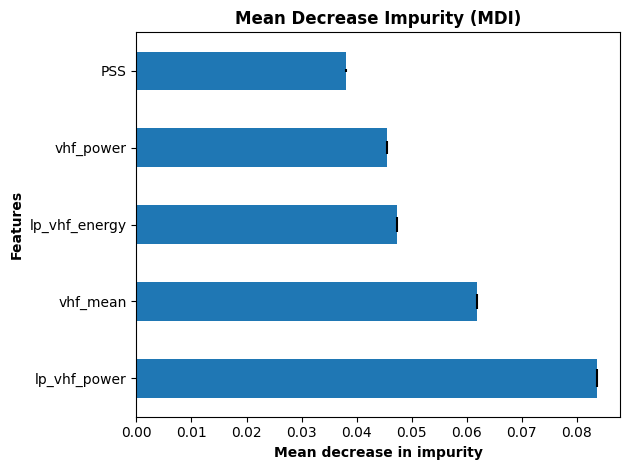

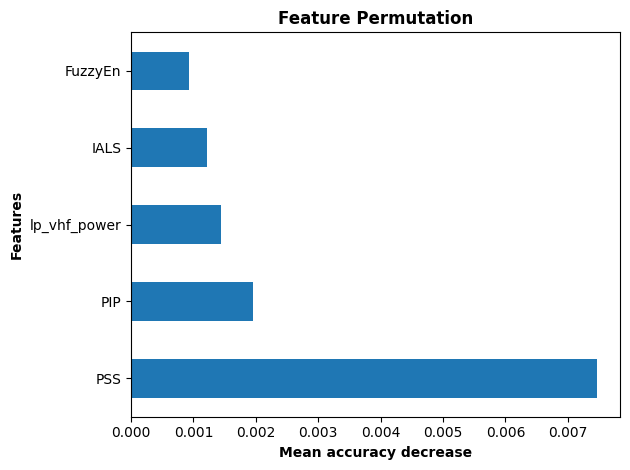

In [32]:
optimize(mapping={ "mental_stress": 1 })

[I 2024-06-29 19:24:10,117] A new study created in RDB with name: random_forest_./data/ecg_features_60s_clean_twa_rqa_60s_0172d56a-fb05-4dfc-9edd-4ef639b5e5a4


  0%|          | 0/5 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/2445948 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/644536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2445948 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/644536 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2487305 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/603179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2487305 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/603179 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2466617 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/623867 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2466617 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/623867 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2476207 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/614277 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2476207 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/614277 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2485859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/604625 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2485859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/604625 [00:00<?, ? examples/s]

[I 2024-06-30 05:52:50,384] Trial 0 finished with value: 0.8871691978169048 and parameters: {'max_depth': 5, 'min_samples_split': 200, 'max_features': 12}. Best is trial 0 with value: 0.8871691978169048.
[I 2024-06-30 11:47:08,486] Trial 1 finished with value: 0.8870545274338953 and parameters: {'max_depth': 7, 'min_samples_split': 40, 'max_features': 5}. Best is trial 0 with value: 0.8871691978169048.
[I 2024-06-30 16:53:08,981] Trial 2 finished with value: 0.8194170559555736 and parameters: {'max_depth': 2, 'min_samples_split': 180, 'max_features': 10}. Best is trial 0 with value: 0.8871691978169048.
[I 2024-07-01 04:32:54,580] Trial 3 finished with value: 0.891407628061029 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'max_features': 15}. Best is trial 3 with value: 0.891407628061029.
[I 2024-07-01 10:20:01,483] Trial 4 finished with value: 0.8898080302050555 and parameters: {'max_depth': 9, 'min_samples_split': 50, 'max_features': 5}. Best is trial 3 with value: 0.89140

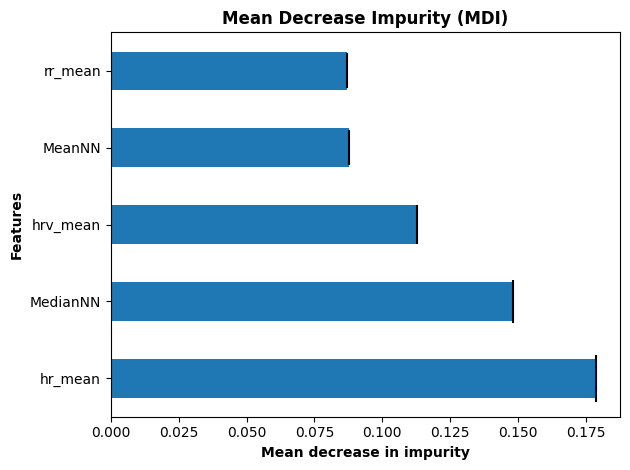

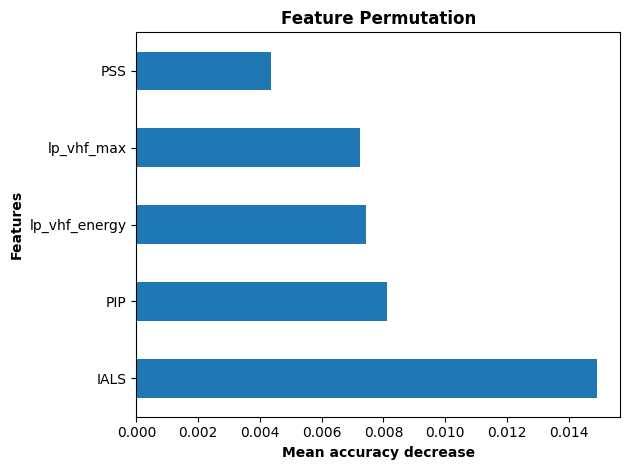

In [33]:
optimize(mapping={ "high_physical_activity": 1 })

[I 2024-07-02 14:41:23,305] A new study created in RDB with name: random_forest_./data/ecg_features_60s_clean_twa_rqa_60s_c169f1bf-8467-472d-9c92-c7ef301802ea


  0%|          | 0/5 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/2445948 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/644536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2445948 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/644536 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2487305 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/603179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2487305 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/603179 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2466617 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/623867 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2466617 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/623867 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2476207 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/614277 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2476207 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/614277 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2485859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/604625 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2485859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/604625 [00:00<?, ? examples/s]

[I 2024-07-02 22:12:10,891] Trial 0 finished with value: 0.8366528777163548 and parameters: {'max_depth': 5, 'min_samples_split': 200, 'max_features': 12}. Best is trial 0 with value: 0.8366528777163548.
[I 2024-07-03 03:57:59,782] Trial 1 finished with value: 0.8357767933095985 and parameters: {'max_depth': 7, 'min_samples_split': 40, 'max_features': 5}. Best is trial 0 with value: 0.8366528777163548.
[I 2024-07-03 08:10:37,205] Trial 2 finished with value: 0.8106224848441492 and parameters: {'max_depth': 2, 'min_samples_split': 180, 'max_features': 10}. Best is trial 0 with value: 0.8366528777163548.
[I 2024-07-03 20:34:40,422] Trial 3 finished with value: 0.8392360693676739 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'max_features': 15}. Best is trial 3 with value: 0.8392360693676739.
[I 2024-07-04 02:51:06,038] Trial 4 finished with value: 0.8384807707130382 and parameters: {'max_depth': 9, 'min_samples_split': 50, 'max_features': 5}. Best is trial 3 with value: 0.839

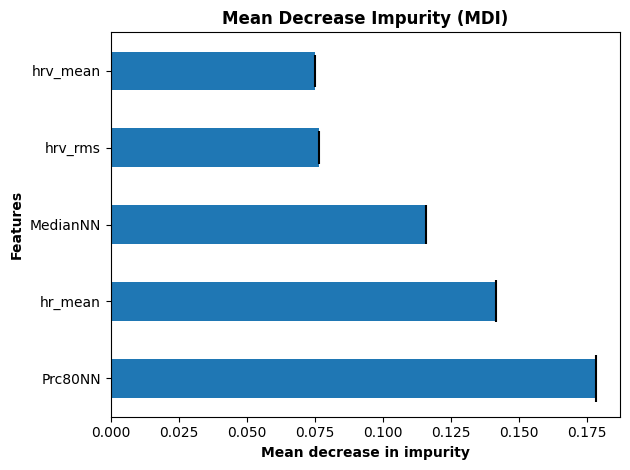

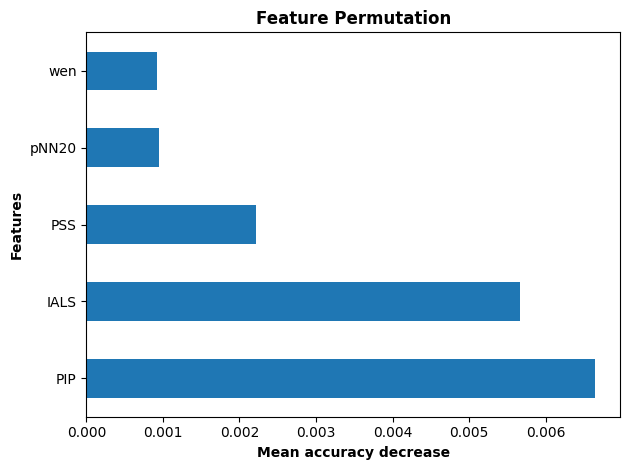

In [34]:
optimize(mapping={ "baseline": -1, "mental_stress": 0, "high_physical_activity": 1 })

[I 2024-07-05 09:52:51,649] A new study created in RDB with name: random_forest_./data/ecg_features_60s_clean_twa_rqa_60s_5549dd3c-5aa7-43e7-8423-77bcd505c4c1


  0%|          | 0/5 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/2445948 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/644536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2445948 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/644536 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2487305 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/603179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2487305 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/603179 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2466617 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/623867 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2466617 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/623867 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2476207 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/614277 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2476207 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/614277 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2485859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/604625 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2485859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/604625 [00:00<?, ? examples/s]

[I 2024-07-05 21:41:22,545] Trial 0 finished with value: 0.6199937000446408 and parameters: {'max_depth': 5, 'min_samples_split': 200, 'max_features': 12}. Best is trial 0 with value: 0.6199937000446408.
[I 2024-07-06 07:01:51,015] Trial 1 finished with value: 0.62572272603826 and parameters: {'max_depth': 7, 'min_samples_split': 40, 'max_features': 5}. Best is trial 1 with value: 0.62572272603826.
[I 2024-07-06 15:42:04,479] Trial 2 finished with value: 0.5910032419556256 and parameters: {'max_depth': 2, 'min_samples_split': 180, 'max_features': 10}. Best is trial 1 with value: 0.62572272603826.
[I 2024-07-07 12:52:05,211] Trial 3 finished with value: 0.6310738353450036 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'max_features': 15}. Best is trial 3 with value: 0.6310738353450036.
[I 2024-07-08 00:20:37,869] Trial 4 finished with value: 0.6290425674389453 and parameters: {'max_depth': 9, 'min_samples_split': 50, 'max_features': 5}. Best is trial 3 with value: 0.631073835

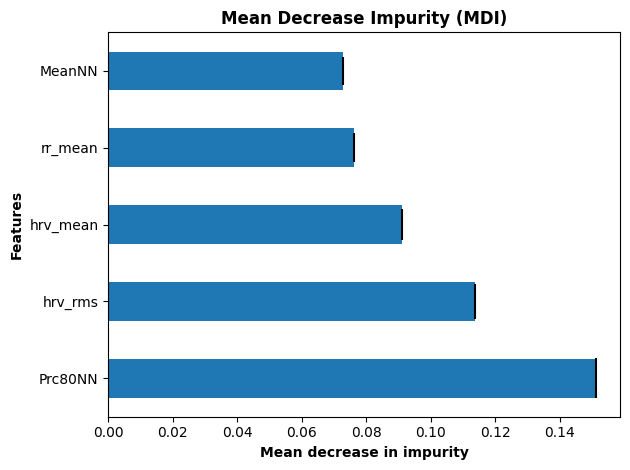

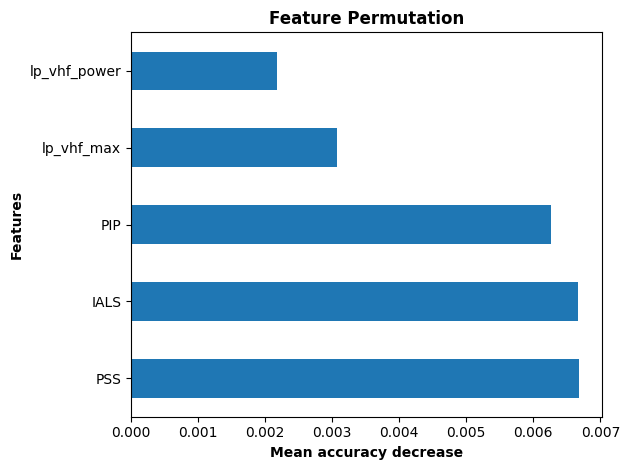

In [36]:
optimize(mapping={ "mental_stress": 1, "high_physical_activity": 2 })

Skipping optimization, using given parameters... {'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}
╒════════════════╤════════════════╤═════════════════════╤════════════════╤══════════════════════════════╤════════════════════════╕
│ Validation F1  │ Test F1        │ Validation Accuracy │ Test Accuracy  │ Validation Balanced Accuracy │ Test Balanced Accuracy │
├────────────────┼────────────────┼─────────────────────┼────────────────┼──────────────────────────────┼────────────────────────┤
│ 29.83% ± 6.15% │ 29.67% ± 1.23% │ 79.47% ± 0.65%      │ 78.95% ± 0.75% │ 58.18% ± 2.23%               │ 57.75% ± 0.42%         │
╘════════════════╧════════════════╧═════════════════════╧════════════════╧══════════════════════════════╧════════════════════════╛


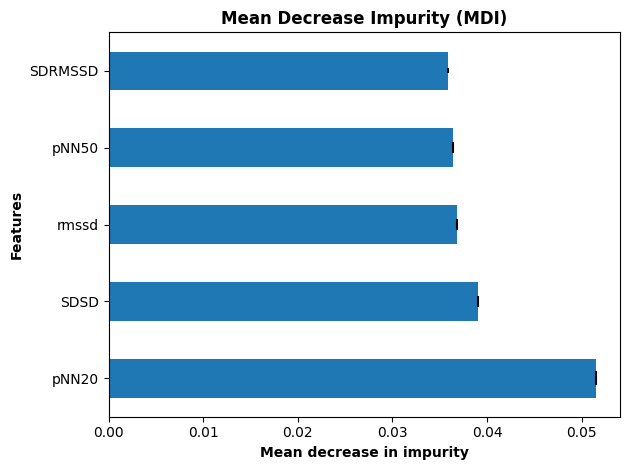

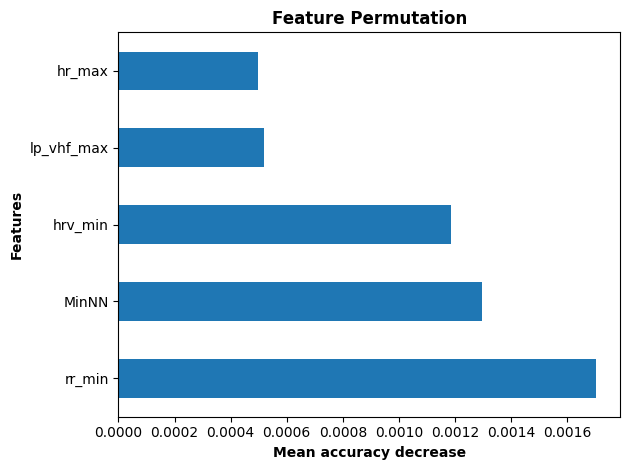

In [18]:
optimize(mapping={ "low_physical_activity": 1 }, best_params={'max_depth': 8, 'min_samples_split': 50, 'max_features': 5})

Skipping optimization, using given parameters... {'max_depth': 8, 'min_samples_split': 50, 'max_features': 5}


Map (num_proc=4):   0%|          | 0/2476207 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/614277 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2476207 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/614277 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2485859 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/792586 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/604625 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2485859 [00:00<?, ? examples/s]

Filter:   0%|          | 0/792586 [00:00<?, ? examples/s]

Filter:   0%|          | 0/604625 [00:00<?, ? examples/s]

╒════════════════╤════════════════╤═════════════════════╤════════════════╤══════════════════════════════╤════════════════════════╕
│ Validation F1  │ Test F1        │ Validation Accuracy │ Test Accuracy  │ Validation Balanced Accuracy │ Test Balanced Accuracy │
├────────────────┼────────────────┼─────────────────────┼────────────────┼──────────────────────────────┼────────────────────────┤
│ 52.65% ± 4.77% │ 56.83% ± 1.64% │ 85.46% ± 1.06%      │ 86.06% ± 0.41% │ 69.69% ± 3.18%               │ 72.96% ± 1.28%         │
╘════════════════╧════════════════╧═════════════════════╧════════════════╧══════════════════════════════╧════════════════════════╛


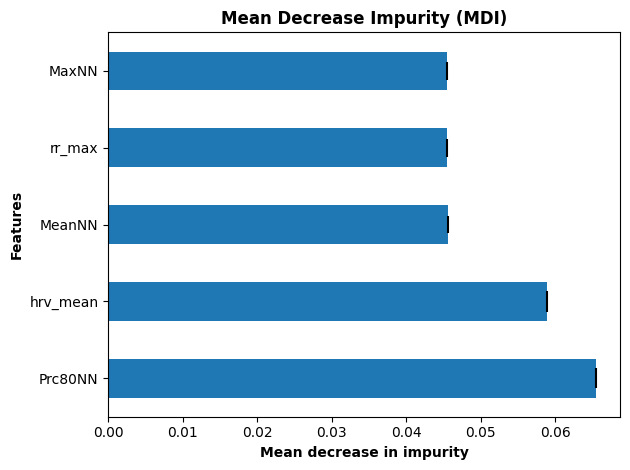

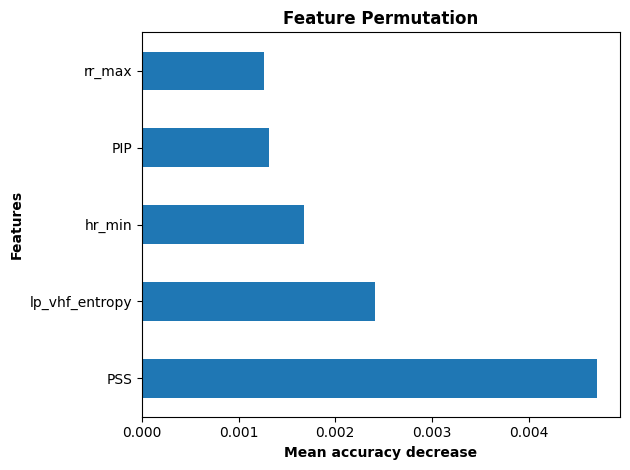

In [19]:
optimize(mapping={ "moderate_physical_activity": 1 }, best_params={'max_depth': 8, 'min_samples_split': 50, 'max_features': 5})